### Imports

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Вспомогательные функции вынесены в отдельный файл
from agent import Agent
from misc import train_dqn, watch_agent, plot_scores

### Environment

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
state_size = state_size[0]

State shape:  (8,)
Number of actions:  4


### Agents

### Untrained agent

In [3]:
untrained_agent = Agent(state_size, action_size, seed=0)
watch_agent(untrained_agent, env)

В качестве baseline возьмём классическую DQN-архитектуру со следующими параметрами и особенностями:
* Learning rate: 0,0005
* Discount factor: 0.99 - то, как уменьшается ценность последующих (менее прогнозируемых) действий в Q.
* Batch size: 64 - мини-батч, на котором будет происходить обучение
* Два fully-connected слоя с размерами 64 и один на action size (4)
* Функции активации ReLU на первые два слоя и softmax на выход

Не была применена переодическая фиксация Q-target'ов, т.к с ней результат не изменялся.

### [Default DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

![DQN](./img/dqn.svg)

Episode 100	Average Score: -130.85
Episode 200	Average Score: -66.622
Episode 300	Average Score: 24.144
Episode 400	Average Score: 180.55
Episode 418	Average Score: 200.02
Environment solved in 318 episodes!	Average Score: 200.02


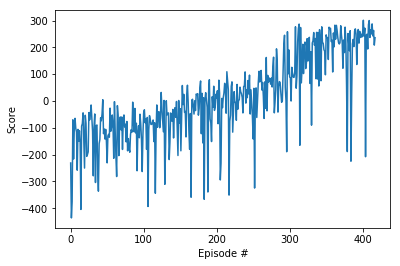

In [4]:
scores_default = train_dqn(untrained_agent, env, save_as='checkpoint_default')
plot_scores(scores_default)

## [Double](https://arxiv.org/abs/1509.06461) DQN

Идея Double Q-learning заключается в уменьшении переоценки через замену max-операции в выбор действия и его подсчёт. Хотя и не полностью разделённая, архитектура Double DQN кандидата для второй V(s) функции без нужды в дополнительной нейронной сети.  Поэтому предлагается оценивать greedy policy согласно локальной нейронке, но использовать целевую для подсчёта значения.
Т.е, вместо получения максимальных прогнозируемых значений q для target model
```python
Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
```
Мы используем greedy-actions для будущего состояния в local model, чтобы потом получить значение q из target model по Q_local_argmax
```python
Q_local_argmax = self.qnetwork_local(next_states).detach().argmax(dim=1).unsqueeze(1)
Q_targets_next = self.qnetwork_target(next_states).gather(1, Q_local_argmax).detach()
```

Episode 100	Average Score: -142.78
Episode 200	Average Score: -54.458
Episode 300	Average Score: 32.027
Episode 391	Average Score: 200.45
Environment solved in 291 episodes!	Average Score: 200.45


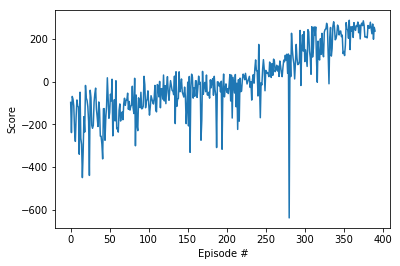

In [4]:
agent = Agent(state_size, action_size, seed=0, double=True)
scores_double = train_dqn(agent, env, save_as='checkpoint_double')
plot_scores(scores_double)

In [ ]:
agent = Agent(state_size, action_size, seed=0, double=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_double.pth'))
watch_agent(agent, env)

## [Dueling](https://arxiv.org/abs/1511.06581) DQN

На интуитивном уровне, dueling-архитектура просчитывает отдельно ценность состояния (state) и action. Это особенно полезно в состояниях где действия в нём не влияют на окружение в какой-либо мере.

Также был добавлен дополнительный слой размером 32.

визуальный пример различия dqn (сверху) и dueling dqn:
![Dueling-DQN](files/img/distinction.jpg)

Cлои стандартной DQN
```python3
self.fc1 = nn.Linear(state_size, fc1_size)
self.fc2 = nn.Linear(fc1_size, fc2_size)
self.fc3 = nn.Linear(fc2_size, action_size)
```
Cлои Dueling DQN
```python3
self.fc1 = nn.Linear(state_size, fc1_size)
self.fc2 = nn.Linear(fc1_size, fc2_size)
# V(s)
self.fc3_v = nn.Linear(fc2_size, fc3_size)
self.fc4_v = nn.Linear(fc3_size, 1)
# A(s,a)
self.fc3_a = nn.Linear(fc2_size, fc3_size)
self.fc4_a = nn.Linear(fc3_size, action_size)
```
На выход в дуэльной DQN идёт:
```python3
# Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
x = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.action_size)
```

Episode 100	Average Score: -129.72
Episode 200	Average Score: -78.068
Episode 300	Average Score: -3.728
Episode 382	Average Score: 200.27
Environment solved in 282 episodes!	Average Score: 200.27


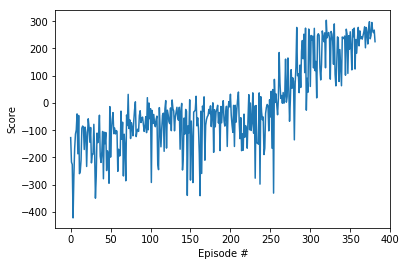

In [3]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
scores_dueling = train_dqn(agent, env, save_as='checkpoint_dueling')
plot_scores(scores_dueling)

In [3]:
agent = Agent(state_size, action_size, seed=0, dueling=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_dueling.pth'))
watch_agent(agent, env, how_many=6)

Решено в 282 эпизода !

## Dueling Double DQN

Попробуем просто наложить две технологии

Episode 100	Average Score: -129.39
Episode 200	Average Score: -35.824
Episode 300	Average Score: 88.591
Episode 400	Average Score: 190.68
Episode 420	Average Score: 200.88
Environment solved in 320 episodes!	Average Score: 200.88


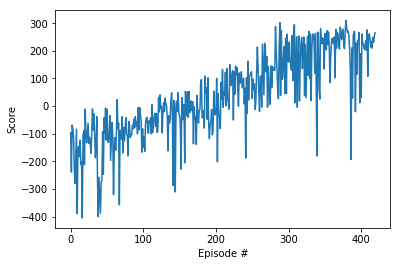

In [4]:
agent = Agent(state_size, action_size, seed=0, dueling=True, double=True)
scores_DDDQN = train_dqn(agent, env, save_as='checkpoint_DDDQN')
plot_scores(scores_DDDQN)

# ):

## Categorical Dueling DQN

In [ ]:
agent = Agent(state_size, action_size, seed=0, dueling=True, discount=True)
scores_DDQN_discount = train_dqn(agent, env, save_as='checkpoint_DDQN_discount')
plot_scores(scores_DDQN_discount)

Episode 100	Average Score: -154.69
Episode 200	Average Score: -42.071
Episode 300	Average Score: 62.045
Episode 393	Average Score: 174.48